In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from corruption_utils import corruptions

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
from src.model import Discriminator, Generator
from src.trainer import GAN

In [4]:
from src.utils import StyledMNISTGenerator, StyledMNIST

In [5]:
np.random.seed(101)
torch.manual_seed(101)
mnist = torchvision.datasets.MNIST(
    "../data", train=True, download=True
)
generator = StyledMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.1,
        corruptions.stripe: 0.15,
        corruptions.zigzag: 0.25,
        corruptions.canny_edges: 0.15,
        lambda x: corruptions.scale(x, 5): 0.15,
        corruptions.brightness: 0.2
    },
)


In [6]:
mnist = StyledMNIST(
    generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)

Generating dataset: 100%|██████████| 60000/60000 [00:14<00:00, 4097.36item/s]


In [7]:
train_loader = DataLoader(mnist, batch_size=128, shuffle=True)

### GAN

In [8]:
model = GAN(
    generator=Generator(z_dim=64),
    discriminator=Discriminator(),
    lr={"D": 2e-4, "G": 1e-4},
    verbose_period=2,
    device=device
)

In [ ]:
d_losses, g_losses = model.fit(21, train_loader)

Epoch 2:   3%|▎         | 16/469 [00:00<00:11, 38.61batch/s, d_loss=0.0286, g_loss=0.473]

### CLEARInfoVAE

In [10]:
from src.trainer import CLEARInfoGAN

In [18]:
model = CLEARInfoGAN(
    z_dim=100,
    num_classes=10,
    lr=2e-5,
    hyperparam={"lambda_info": 0.5},
    verbose_period=2,
    device=device
)

In [19]:
d_losses, g_losses, q_losses = model.fit(13, train_loader)

Epoch 12: 100%|██████████| 469/469 [00:13<00:00, 35.08batch/s, d_loss=0.128, g_loss=3.03, loss_c=0.0784, loss_s=0.102, q_loss=0.0528] 


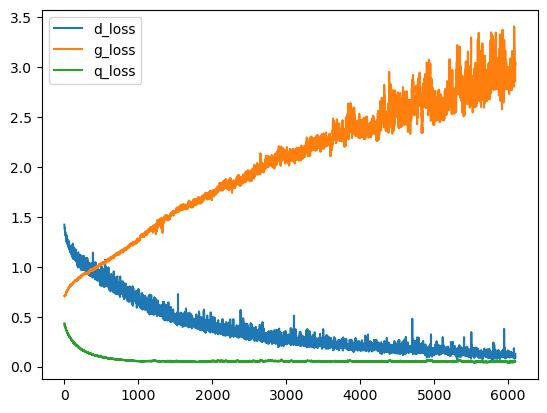

In [20]:
pd.DataFrame(
    {"d_loss": d_losses, "g_loss": g_losses, "q_loss": q_losses}
).plot(kind="line")
plt.show()

In [21]:
model.generator.eval()
z_cs = []
labels = []

samples = []
with torch.no_grad():
    for i in range(10):
        digit_type = (torch.ones(16, dtype=torch.int64) * i).to(model.device)
        torch.manual_seed(1)
        z_raw = torch.randn(16, model.z_dim).to(model.device)
        label_onehot = nn.functional.one_hot(digit_type, 10).to(model.device)
        z_c = model.zc_encoder(torch.cat([z_raw, label_onehot], dim=-1))
        z_s = model.zs_encoder(torch.cat([z_raw, label_onehot], dim=-1))
        z = torch.cat([z_c, z_s], dim=1)[:, :, None, None]
        xhat = model.generator(z).detach().cpu()
        samples.append(xhat)
        z_cs.append(z_c)
        labels.append(digit_type)
z_cs = torch.cat(z_cs, dim=0)
labels = torch.cat(labels, dim=0)

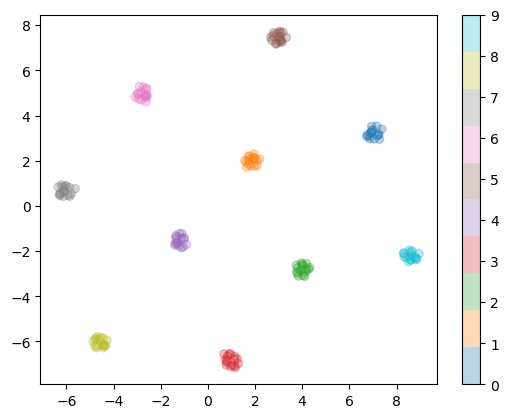

In [22]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
z_cs_tsne = tsne.fit_transform(z_cs.cpu().numpy())
plt.scatter(z_cs_tsne[:, 0], z_cs_tsne[:, 1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='')

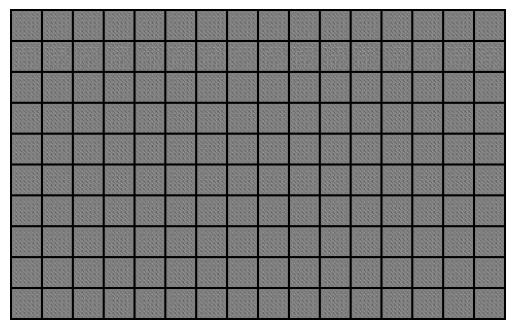

In [23]:
plt.imshow(torch.permute(make_grid(torch.cat(samples, dim=0), nrow=16), (1, 2, 0)))
plt.axis('off')
plt.show()
